# Video game sales

What I am trying to do is see the impact that various factors might have on the sales of video games. The goal is to maximise global sales.

Some background information is that both these datasets were scraped from the website [VGCharts](https://www.vgchartz.com/). I have no idea how this website gets it's data, but the website itself is still getting content updates despite looking fresh out of 2006. I am confident enough in the validity of it's data.



The main dataset I am using is from https://www.kaggle.com/datasets/ashaheedq/video-games-sales-2019?select=vgsales-12-4-2019-short.csv
That dataset is based on this dataset from three years earlier
Dataset from https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
I breifly use the older dataset for correcting errors in the new dataset.

#### Required modules imported below

In [391]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sales = pd.read_csv('vgsales-12-4-2019-short.csv')


## A short description of the program

##### The first thing to know is that I have chosen to keep NaN values in rows where other data could still be good. I still drop a few rows where most of the important data is missing, but for minor columns like ESRB rating it can stay. If I am graphing a specific column ill go ahead and drop it's NaN values. 

The program first imports all modules along with the dataset and assignes the dataset to the pandas dataframe 'sales'.

The next thing I do is define a few functions that help me save some time typing.

Now some heavy cleanup needs to be done to this dataset, so the majority of the program is dedicated to doing just that. 

It drops some NaN rows, combines two columns that do the same thing, amd drops some columns that dont do anything.

Next it merges part of the older dataset from 2016 with sales to fix all the missing critic & user scores.

After that, it converts text based columns to variables, so pandas can eaiser process it.

Finally, it does a little more cleanup, removing some nan values. 

The remaining code is all for generating various graphs.

In [392]:
def percntmiss(val):
    shap = val.shape
    summ = val.isna().sum()
    summ = (summ / shap[0]) * 100
    return summ

def mergesets(set, column):
    sx = set.set_index('Name').to_dict()[column]#This row converts the name column along with one of the score columns into a dictionary
    s = sales['Name'].map(sx) # It then maps the dictionary to the sales dataframe so values are only updated where name == name
    return s.fillna(sales[column]) # I would like to thank stackoverflow for helping me understand where to start googling
# https://stackoverflow.com/questions/60083852/updating-dataframe-column-where-another-column-matches-the-keys-in-a-dictionary

def maketemp(): #makes a temporary copy of sales
    global temp
    temp = sales.copy(deep = True)

def insertvalues(set, column, dict):
    for i in dict:
        set[column].replace(to_replace=dict[i], value=i, inplace=True)


In [393]:
percntmiss(sales)

Rank              0.000000
Name              0.000000
Genre             0.000000
ESRB_Rating      57.658804
Platform          0.000000
Publisher         0.000000
Developer         0.030470
Critic_Score     88.285059
User_Score       99.399555
Total_Shipped    96.725337
Global_Sales     65.201104
NA_Sales         76.763694
PAL_Sales        76.360410
JP_Sales         87.376326
Other_Sales      72.178807
Year              1.754732
dtype: float64

This dataset has a horrible amount of missing data.

There are 55,772 rows in this dataset, and some of these columns have over 90% of the data missing!


The first thing I will do is drop any row where both sales and shipped are null, as any row without that data is useless to me.

I also combine the two into one because they mean the same thing. I think the website this data was scraped off of changed it's naming scheme sometime between updates for this set, so that is why the global sales and total shipped columns are two parts of a whole. I also drop the rank column as I dont really care about it.

In [394]:
sales.dropna(subset=['Total_Shipped','Global_Sales'], how='all', inplace=True)
sales['Global_Sales'] = sales['Global_Sales'].combine_first(sales['Total_Shipped'])
sales.drop(columns='Total_Shipped', inplace=True)
sales.drop(columns='Rank', inplace=True)

percntmiss(sales)

Name             0.000000
Genre            0.000000
ESRB_Rating     31.089351
Platform         0.000000
Publisher        0.000000
Developer        0.018831
Critic_Score    77.116091
User_Score      98.860748
Global_Sales     0.000000
NA_Sales        38.969965
PAL_Sales       37.910743
JP_Sales        66.843988
Other_Sales     26.927785
Year             0.178891
dtype: float64

Next, Im tackling the user score and critic score. VGChartz seems to have lost most of this information sometime between when the set was originally scraped in 2016 and now, so I will use the 2016 set to fix a few of the missing scores. It shouldn't matter that there is a three year gap between the datasets, because most of these games are quite old. The user & critic review scores will not suddenly change ten years after the game released. Newer games released between 2016 and 2019 also will not have much of an impact as their score will likley just be NaN.


In [395]:
sales2 = pd.read_csv('Video_Games_Sales_as_at_22_Dec_2016.csv')
merge = sales2[['Name', 'Critic_Score', 'User_Score', 'Rating']].copy(deep=True)
merge.dropna(subset=['Critic_Score','User_Score', 'Rating'], how='all', inplace=True)
merge = merge.rename(columns={"Rating": "ESRB_Rating"})

#above reads the older dataset and makes a small dataframe with just the columns I want to combine.

sales['User_Score'] = mergesets(merge, 'User_Score')
sales['Critic_Score'] = mergesets(merge, 'Critic_Score') #These call the function I wrote earlier that merges the datasets.
sales['ESRB_Rating'] = mergesets(merge, 'ESRB_Rating')
sales["ESRB_Rating"] = sales["ESRB_Rating"].replace('K-A', "E")

del merge
del sales2
#getting rid of these variables to free up memory so visual studio stops using 3 gigs of ram
percntmiss(sales)

Name             0.000000
Genre            0.000000
ESRB_Rating     28.471895
Platform         0.000000
Publisher        0.000000
Developer        0.018831
Critic_Score    53.431880
User_Score      49.887016
Global_Sales     0.000000
NA_Sales        38.969965
PAL_Sales       37.910743
JP_Sales        66.843988
Other_Sales     26.927785
Year             0.178891
dtype: float64

Merging the older dataset into sales has filled in reviews for nearly 50% of the missing columns! 

The next thing to do is to assign numeric values to the text fields. Simply replacing "Wii" with 1, "PS2" with 2 an so on. This is so pandas can process it. I also make dictionarys with the values for easy retrival of what each number corresponds to.

I also declared a function at the start to undo this and reinsert text, for easy reading of graphs.

In [396]:
genres = sales["Genre"].unique()
ix = 0
for i in genres:
    sales.replace(to_replace=i, value=ix, inplace=True)
    ix += 1
genreKey = dict(zip(genres, sales["Genre"].unique()))

In [397]:
platforms = sales["Platform"].unique()
ix = 0
for i in platforms:
    sales.replace(to_replace=i, value=ix, inplace=True)
    ix += 1
platformKey = dict(zip(platforms, sales["Platform"].unique()))

ESRB rating is a little complicated because there are a few NaN values in it. If a NaN value makes it into this function, then the dictionary will have NaN as one of the keys. Because Nan != Nan, I can't refrence whatever element that NaN was in, so I need to get rid of them somehow. 

I do not want to drop the rows with NaN values right now, as they could still be useful in other columns. Instead of doing something complex and fixing the logic in how this runs, I just temporaily changed "NaN" to "replaceme". After the ratings were converted, "replaceme" was converted to 1, so I just replaced 1 with np.nan

All this because like I mentioned up top, I do not want to blanket drop rows with NaN because other values in that row could still be good.

In [398]:
sales["ESRB_Rating"] = sales["ESRB_Rating"].fillna("replaceme")
esrb = sales["ESRB_Rating"].unique()
ix = 0
for i in esrb:
    sales.replace(to_replace=i, value=ix, inplace=True)
    ix += 1
esrbKey = dict(zip(esrb, sales["ESRB_Rating"].unique()))
sales["ESRB_Rating"] = sales["ESRB_Rating"].replace(1, np.nan)
del esrbKey['replaceme']


Now just time to convert the user score column from the string datatype it was before to a float. Also, replace any dates of 2020 with nan. This dataset is from 2019 and any 2020 dates are errors.

In [399]:
sales["User_Score"] = sales["User_Score"].replace('NaN', np.nan)
sales["User_Score"] = sales["User_Score"].replace('tbd', np.nan)
sales['User_Score'] = sales['User_Score'].astype(float) #This converts the user score from the string it was to a float
sales["Year"] = sales["Year"].replace(2020, np.nan)

# Now time for some graphs!
The first thing I will do is make a correlation matrix, and sort it. This might give me insights that I wouldn't have thought about at first. 

Actually, first I will do head() to show what sales looks like, but THEN I will do the matrix!

In [400]:
sales.head()

,Name,Genre,ESRB_Rating,Platform,Publisher,Developer,Critic_Score,User_Score,Global_Sales,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year
0,Wii Sports,0,0.0,0,Nintendo,Nintendo EAD,76.0,8.0,82.86,NaN,NaN,NaN,NaN,2006.0
1,Super Mario Bros.,1,NaN,1,Nintendo,Nintendo EAD,10.0,NaN,40.24,NaN,NaN,NaN,NaN,1985.0
2,Mario Kart Wii,2,0.0,0,Nintendo,Nintendo EAD,82.0,8.3,37.14,NaN,NaN,NaN,NaN,2008.0
3,PlayerUnknown's Battlegrounds,3,NaN,2,PUBG Corporation,PUBG Corporation,NaN,NaN,36.60,NaN,NaN,NaN,NaN,2017.0
4,Wii Sports Resort,0,0.0,0,Nintendo,Nintendo EAD,80.0,8.0,33.09,NaN,NaN,NaN,NaN,2009.0


This tells us that regional sales have the highest impact on global sales. Who wouldve thought that two parts make up a whole! However, it does also show some interesting things. For example, Japan's sales are impacted much more by the release year or genre than other regions. Ill go ahead and do this again with a diffrent method of calculating the correlation.

In [401]:
sales.corr(method='spearman').abs().unstack().sort_values(ascending=False).drop_duplicates()

Genre         Genre           1.000000
Global_Sales  NA_Sales        0.925544
Other_Sales   Global_Sales    0.869010
Global_Sales  PAL_Sales       0.826996
Other_Sales   PAL_Sales       0.783890
NA_Sales      Other_Sales     0.762221
              PAL_Sales       0.654575
JP_Sales      Global_Sales    0.547735
User_Score    Critic_Score    0.496311
Genre         ESRB_Rating     0.331826
JP_Sales      Year            0.324369
User_Score    Year            0.287983
              JP_Sales        0.247634
Critic_Score  NA_Sales        0.240027
Global_Sales  Critic_Score    0.233745
PAL_Sales     Critic_Score    0.228599
Critic_Score  Other_Sales     0.209256
Year          Platform        0.186683
ESRB_Rating   Year            0.186200
Year          Genre           0.165004
Genre         JP_Sales        0.155404
              Global_Sales    0.154089
User_Score    Platform        0.145351
Year          Other_Sales     0.144478
Global_Sales  Year            0.144132
PAL_Sales     Platform   

The spearman method works better for me, so that is what I will use for sales.corr() from now on.

#### Lets go ahead and see what pandas thinks impacts global sales. 
Will also plot global sales vs other datapoints to see if there is anything we can spot that maybe the correlation calculations can't because of all the outliers.

Text(0.5, 1.0, 'Correlation to global sales')

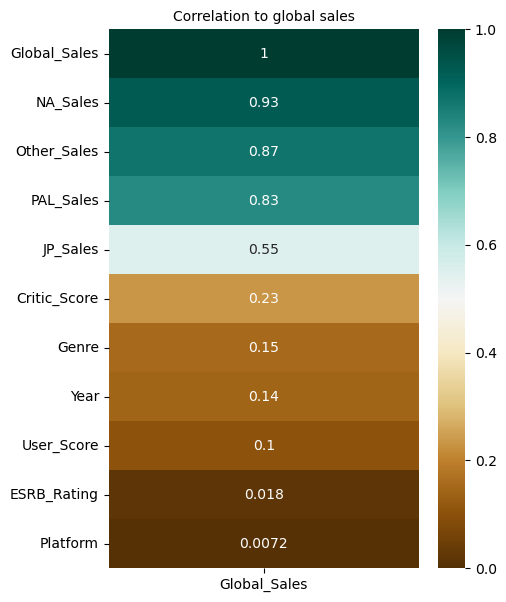

In [402]:
plt.figure(figsize=(5, 7))
gsales = sns.heatmap(sales.corr(method="spearman")[['Global_Sales']].abs().sort_values(by='Global_Sales', ascending=False), vmin=0, vmax=1, annot=True, cmap='BrBG')
gsales.set_title('Correlation to global sales', fontdict={'fontsize':10})

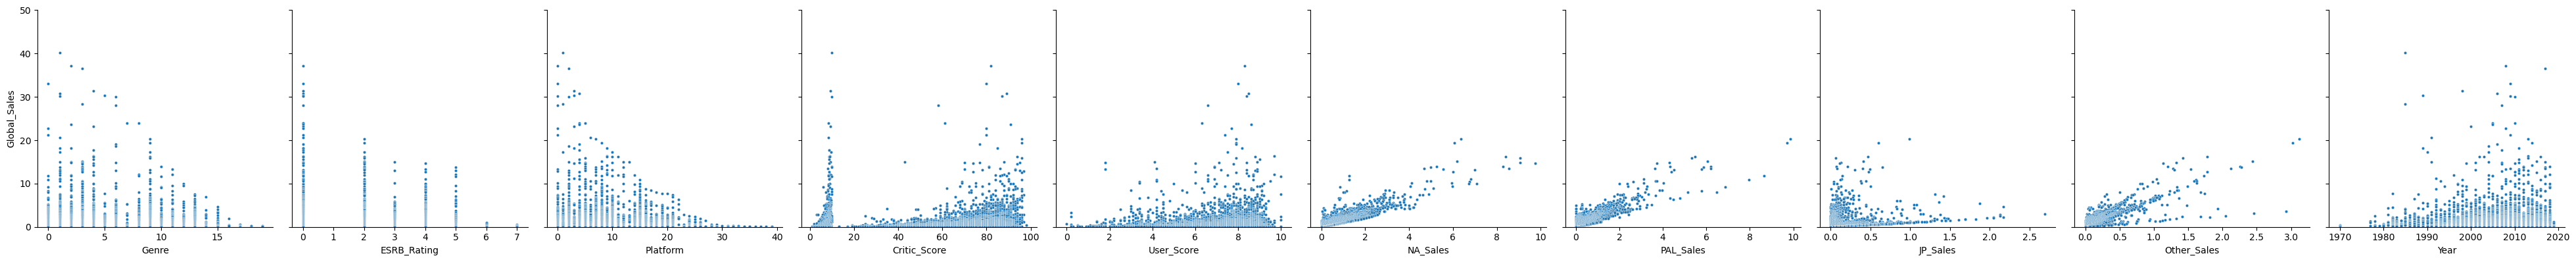

In [403]:
plot = sns.PairGrid(sales, y_vars=["Global_Sales"], x_vars=['Genre', 'ESRB_Rating', 'Platform', 'Critic_Score', 'User_Score', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales', 'Year'], height=4)
plot.map(sns.scatterplot, s=10)
plot.set(ylim=(0,50))

The pandas correlation shows that the platform a game was released on has little effect, but looking at the above graph, there is a steady curve. Maybe this is because the more pouplar games were released on older platforms? Lets take a closer look.

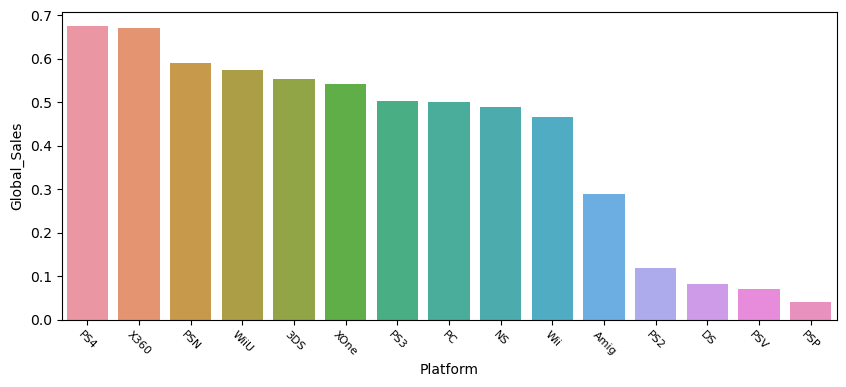

In [404]:

maketemp()
insertvalues(temp, "Platform", platformKey)
temp = temp[temp.Year >= 2013]
tmean = temp.groupby(['Platform']).mean()
tmean = tmean.sort_values(by='Global_Sales', ascending=False)
plt.figure(figsize=(10,4))
plot = sns.barplot(data = tmean, x=tmean.index, y="Global_Sales")
plt.setp(plot.xaxis.get_majorticklabels(), rotation=-45, fontsize=8)
plt.show()

For the above graph, I only included values from after 2013. There is no point in releasing a game for a console no longer in production. The two major console lineups are the top selling. Playstation and Xbox. PSN is playstation's digital store. To max sales for our game we need to release it for the playstation and xbox.

Another graph we can check out is the ESRB rating.

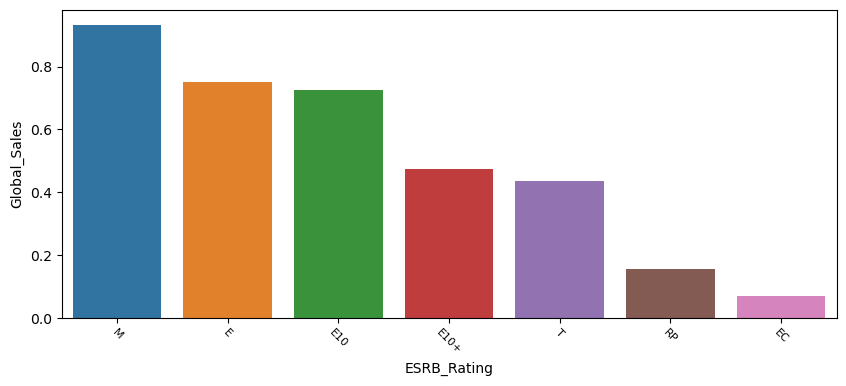

In [405]:
maketemp()
insertvalues(temp, "ESRB_Rating", esrbKey)
temp = temp[temp.Year >= 2013]
tmean = temp.groupby(['ESRB_Rating']).mean()
tmean = tmean.sort_values(by='Global_Sales', ascending=False)
plt.figure(figsize=(10,4))
plot = sns.barplot(data = tmean, x=tmean.index, y="Global_Sales")
plt.setp(plot.xaxis.get_majorticklabels(), rotation=-45, fontsize=8)
plt.show()

The ESRB ratings work on a scale, telling you if a game is suited for children or not. Here are the ratings:

RP: Rating Pending. The ESRB has not rated this game yet.

EC: Early childhood, meant for small children.

E or K.A: Everyone. K.A was another way of saying E for everyone.

E10 or E10+: Suitable for children ages ten and over.

T: Teen, suitable for ages 13 and up.

M: Mature, suitable for ages 17 and up.

**************************

The pouplar catagory is mature games. This category usually contains shooters, one of the most pouplar game genres ever. Games that feature too much 'adult content' such as violence, smoking/drusg/alcohol use, or frequent swearing will also land a spot in the M category. Like a G rated movie vs an R rated movie.

The second most pouplar game category is E. This makes sense, as E is for Everyone! The more people a game can be sold to, the more it will be sold.

The two extremes being the most pouplar make plenty of sense. If you are a parent buy a game for your kid, you probably want them to get an E rated game and not the more explicit T rated game. If you are looking to play a fun shooter game, a M rated game will probably be more realistic than a T rated game. 

So, our game should be rated either M, or E depending on the Genre. Lets see what we should do for that.

*********************

#### Lastly, lets check out Genre

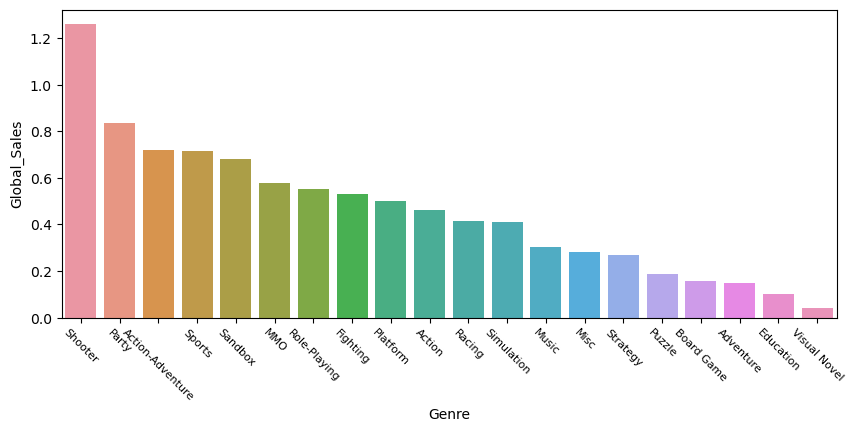

In [406]:
maketemp()
insertvalues(temp, "Genre", genreKey)
temp = temp[temp.Year >= 2013]
tmean = temp.groupby(['Genre']).mean()
tmean = tmean.sort_values(by='Global_Sales', ascending=False)
plt.figure(figsize=(10,4))
plot = sns.barplot(data = tmean, x=tmean.index, y="Global_Sales")
plt.setp(plot.xaxis.get_majorticklabels(), rotation=-45, fontsize=8)
plt.show()

Genre is another variable where I filtered the results to 2013 onwards, because people's intrests change. Without filtering, platformers are the top spot. If we tried to release a platformer today, it would be a middle of the road release.
So if we were to combine these three variables to see what kind of game we should make, the game should be a shooter, rated M, released Xbox and Playstation. Lets go back to the heatmap to see if there is anything else we should try to do.

Text(0.5, 1.0, 'Correlation to global sales')

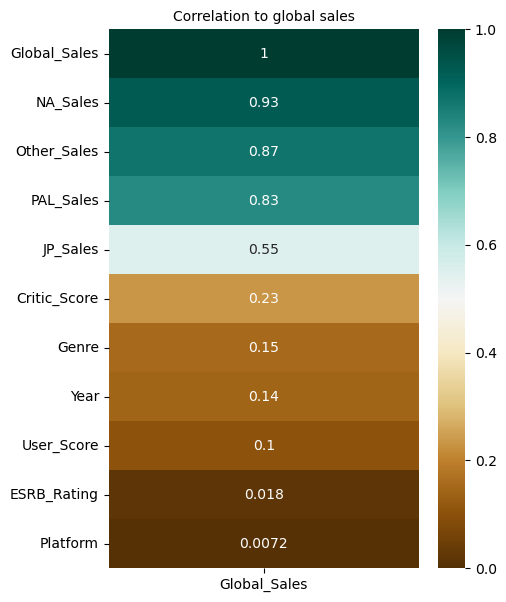

In [407]:
plt.figure(figsize=(5, 7))
gsales = sns.heatmap(sales.corr(method="spearman")[['Global_Sales']].abs().sort_values(by='Global_Sales', ascending=False), vmin=0, vmax=1, annot=True, cmap='BrBG')
gsales.set_title('Correlation to global sales', fontdict={'fontsize':10})

Critic scores stick out for having a high correlation with sales, so lets check them and user scores out

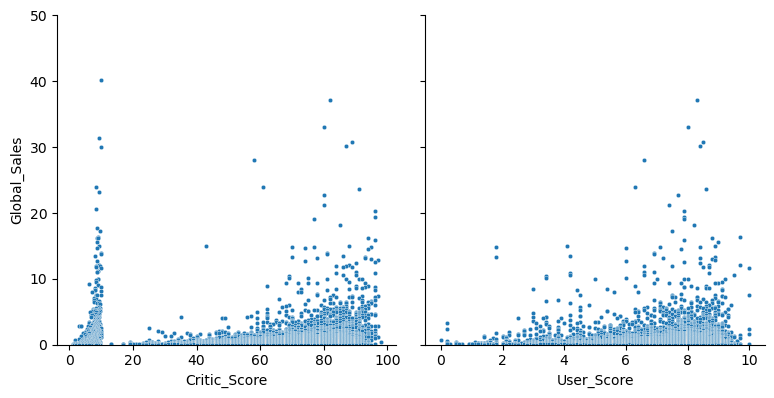

In [408]:
plot = sns.PairGrid(sales, y_vars=["Global_Sales"], x_vars=['Critic_Score', 'User_Score'], height=4)
plot.map(sns.scatterplot, s=10)
plot.set(ylim=(0,50))

In general, the higher a critic or user rates a game, the more it will sell. However, there is a spike of low critic scores that seem to push sales up. To find out why, we can simply look at the number of scores. 

<AxesSubplot:xlabel='Critic_Score', ylabel='Count'>

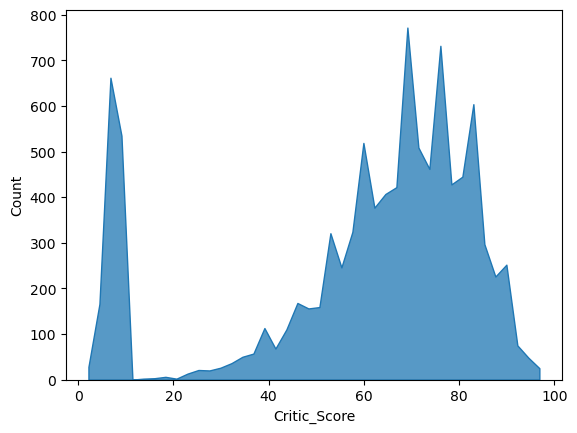

In [409]:
sns.histplot(sales, x="Critic_Score", element="poly")

The spike at the low end is because of the amount of low critic reviews there are. We can safely ignore them. The correlation between critic scores and sales is simply the more critics scoring the game, the more sales. 

To take advantage of this, we send out copies of the game for free to critics to try to get them to review it. Even if they do not like it, it still works.

# Wrapping up

The strategy for gaining the most sales globaly is to focus on pouplar consoles, like Xbox and Playstation, and try to add shooter elements to the game. A "M" rating should also help the game sell more. Lastly, try to get as many critics to review the game as possible. The more critics telling their audience about the game, the more people will see the game. 

These strategies can also apply to specific regions. If you were a local company who doesn't have the reach to sell overseas, you could use the NA_Sales column instead of Global_Sales. 

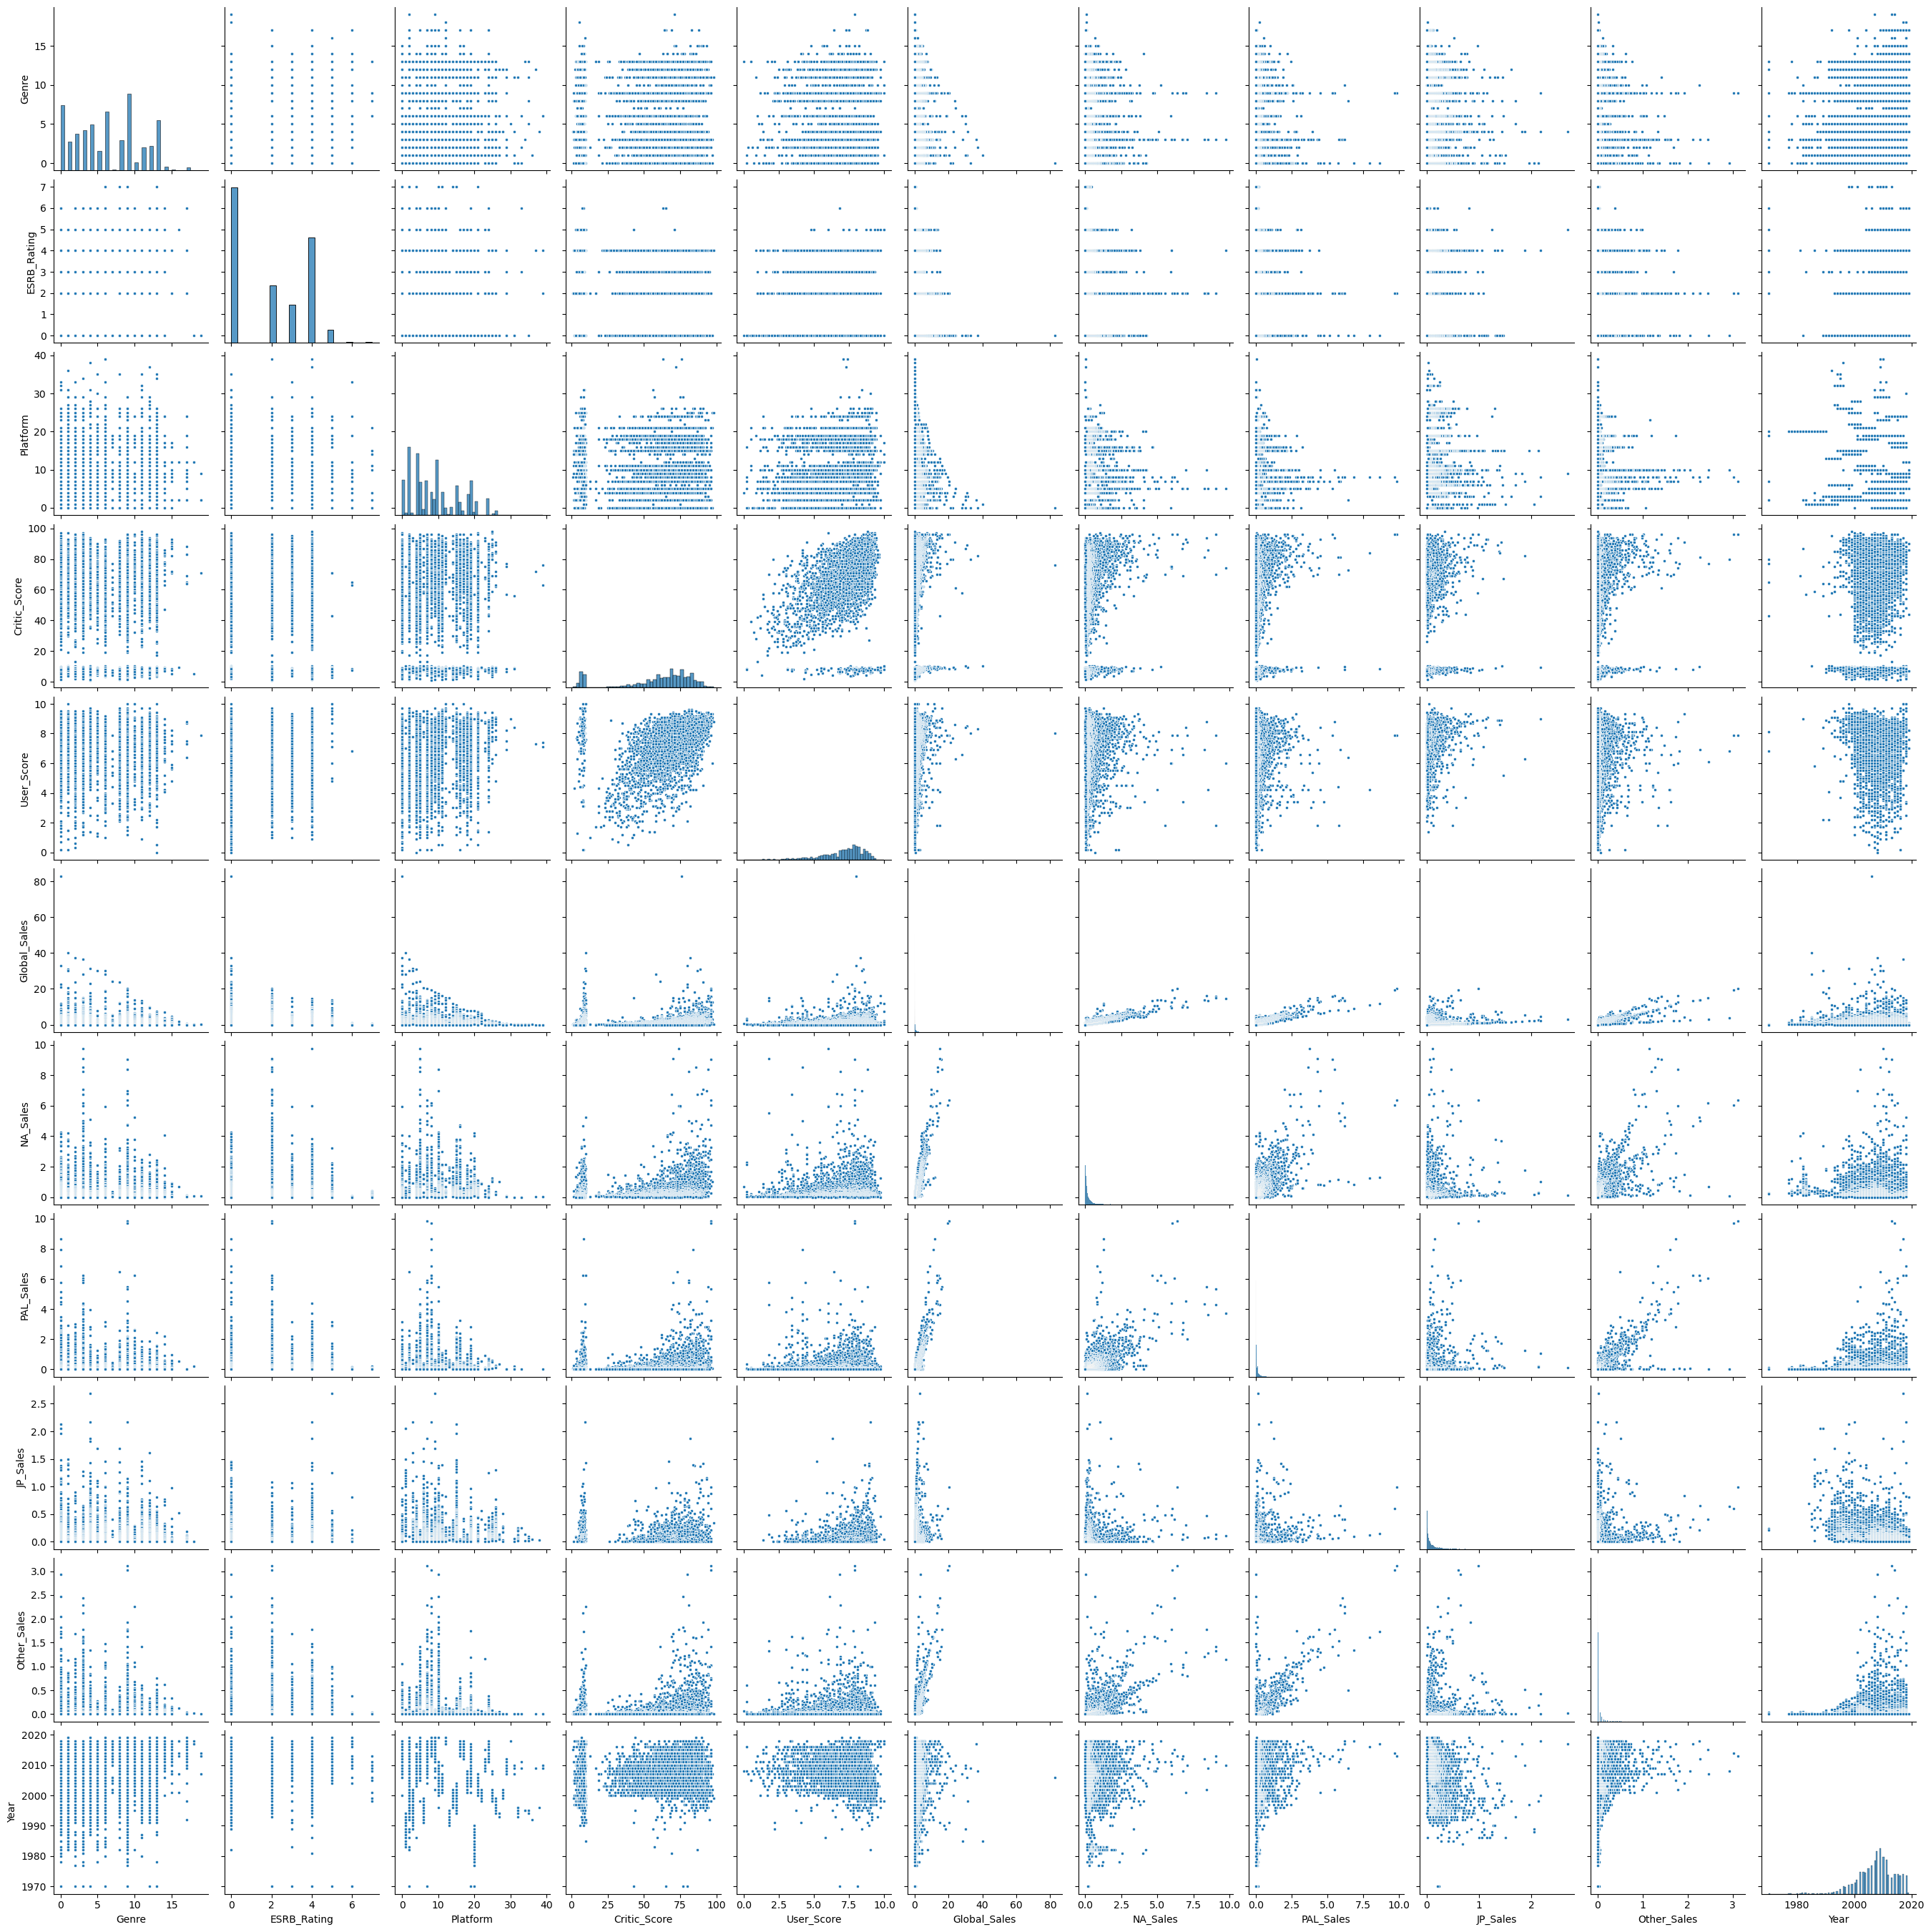

In [410]:
sns.pairplot(sales, markers=".")
plt.show()                                   #save this one for when you aren't hitting run all